# Markowitz Mean Variance Model

Dependencies:
- `pandas`
- `pandas_datareader`

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter

from finance import *
from IPython.display import display, HTML

matplotlib.style.use('ggplot')
# rectify_font()

In [2]:
stock_indices = [
    'SBIN.NS',
    'HDFCBANK.NS',
    'ASIANPAINT.NS',
    'ACC.NS',
    'HCLTECH.NS',
    'YESBANK.NS',
    'KOTAKBANK.NS',
    'WIPRO.BO',
    'MARUTI.BO',
    'ITC.BO',
    'COALINDIA.BO',
    'BHARTIARTL.BO'
]

# Weekly data from 2017
historical_data = get_stocks_data(stock_indices,start_date=datetime.datetime(2016,5,1), interval='w')
closing_price = historical_data['Close']
rate_of_return = get_rate_of_return(closing_price)

We use weekly data, so the expected return is a weekly return and risk is a weekly risk.

Let $p_i$ be this stock price at $i^{th}$ month. Then Rate of Return will be defined as

$$\text{Rate of Return } (r_i) =  \frac{p_{i+1}-p_i}{p_i}$$

In [3]:
ror_covariance = rate_of_return.cov()
ror_mean = rate_of_return.mean()
ror_std = rate_of_return.std()

$$ Risk = \Omega = \text{Covariance between rate of return of stocks} $$
$$ Cov(X, Y) = E[(X-\overline{X})(Y-\overline{Y})] = \frac{\sum_{i=0}^{n}{(X-\overline{X})(Y-\overline{Y})}}{n-1} $$

$$ \text{Average Return} = \mu = E[X] $$



$$ \begin{aligned}
& (QP_1)\;\underset{w}{\text{min}} & & w^T \Omega w \\ 
&\text{subject to} & & w^Te=1
\end{aligned}$$


$$\begin{aligned}
& (QP_2)\;\underset{w}{min} 
& & w^T \Omega w \\
& \text{subject to} 
& & e^Tw = 1 \\
& 
& & w^T\mu = R
\end{aligned}$$

In [4]:
w_optimal, min_risk, min_risk_ror = get_optimial_portfolio(ror_mean, ror_covariance)
max_ror = max(ror_mean)

# For plotting the risk vs ror plot
p_ror = np.linspace(1e-10, max_ror+0.005, 20)
p_risk = np.zeros(20)

In [ ]:
# Getting optimal portfolio for different values of return
for i, ror_value in enumerate(p_ror):
    port, p_risk[i], _ = get_optimial_portfolio(ror_mean, ror_covariance, rate_of_return=ror_value) 
    print ror_value, p_risk[i], port

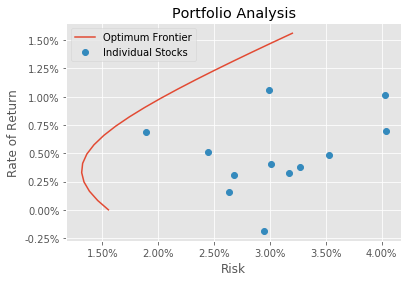

In [6]:
plot = plt.figure()

optimum_legend, = plt.plot(p_risk, p_ror, label="Optimum Frontier")
stocks_legend, = plt.plot(ror_std, ror_mean, 'o', label="Individual Stocks")
plt.xlabel("Risk")
plt.ylabel("Rate of Return")
plt.title("Portfolio Analysis")
plt.legend(handles = [optimum_legend, stocks_legend])

ax = plot.get_axes()[0]
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.show()

In [7]:
rate_of_return.loc['ror_mean'] = ror_mean
rate_of_return.loc['ror_std'] = ror_std
# display(rate_of_return)




# Two Fund Theorem
Any two effifient porftolio generates the efficient frontiers

In [8]:
w1, r1, ror1 = get_optimial_portfolio(ror_mean, ror_covariance, rate_of_return=0.01)
w2, r2, ror2 = get_optimial_portfolio(ror_mean, ror_covariance)

In [9]:
def get_weighted_portfolio(ror_mean, ror_covariance, w1, w2, l):
    w_new = l*w1+(1-l)*w2
    m = (ror_mean.values.ravel()*w_new.values.ravel()).sum()
    r =np.sqrt(w_new.transpose().dot(ror_covariance).dot(w_new).values.ravel()[0])
    return w_new, r, m

In [10]:
p_ror = np.zeros(50)
p_risk = np.zeros(50)

for i, l in enumerate(np.linspace(-1, 2, 50)):
    _, p_risk[i], p_ror[i] = get_weighted_portfolio(ror_mean, ror_covariance, w1, w2, l) 

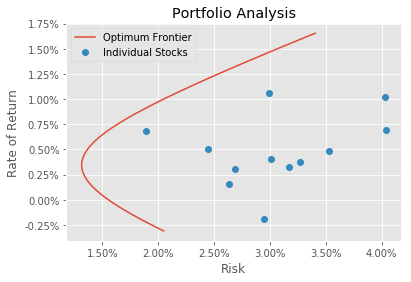

In [11]:
plot = plt.figure()

optimum_legend, = plt.plot(p_risk, p_ror, label="Optimum Frontier")
stocks_legend, = plt.plot(ror_std, ror_mean, 'o', label="Individual Stocks")
plt.xlabel("Risk")
plt.ylabel("Rate of Return")
plt.title("Portfolio Analysis")
plt.legend(handles = [optimum_legend, stocks_legend])

ax = plot.get_axes()[0]
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.show()

# Capital Market Line


In [12]:
bond_return_rate = 0.0001
cov_inv = np.linalg.inv(ror_covariance.values)
w_capital_market_point = cov_inv.dot(ror_mean-bond_return_rate)
w_capital_market_point = w_capital_market_point/w_capital_market_point.sum()

In [13]:
w_capital_market_point = pd.DataFrame(w_capital_market_point, ror_covariance.columns, ['weights'])

In [14]:
risk_market_point, return_market_point = get_risk_and_return(ror_mean, ror_covariance, w_capital_market_point)

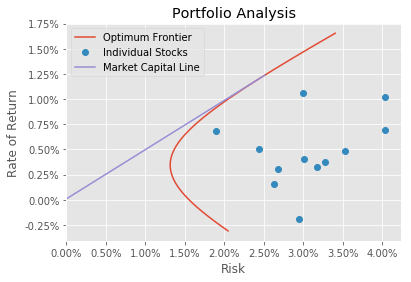

In [15]:
plot = plt.figure()

optimum_legend, = plt.plot(p_risk, p_ror, label="Optimum Frontier")
stocks_legend, = plt.plot(ror_std, ror_mean, 'o', label="Individual Stocks")
capital_line_legend, = plt.plot([0, risk_market_point], [bond_return_rate, return_market_point], label="Market Capital Line")
plt.xlabel("Risk")
plt.ylabel("Rate of Return")
plt.title("Portfolio Analysis")
plt.legend(handles = [optimum_legend, stocks_legend, capital_line_legend])

ax = plot.get_axes()[0]
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
x_ax_range = list(ax.get_xlim())
x_ax_range[0] = 0
ax.set_xlim(x_ax_range)
plt.show()